In [87]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image


In [88]:
def aperture(height,width,apHorz,apVert,apWidth,apRad):
    scene = np.zeros((height,width,3))
    scenex = np.arange(0,width,1)
     
    apMag = 255
    
    scene[:,apHorz - apWidth:apHorz + apWidth,2] = apMag
    scene[:,:,2] += apMag * np.exp(-((scenex-apHorz)/(apWidth * 2))**2)

    scene[apVert-apRad:apVert+apRad,:,2] = 0
    scene = scene.astype("uint8")
    return scene



In [89]:
def solve_R1(f, R2, d, n):
    """
    Solve for R1 given focal length f, R2, thickness d, and refractive index n.
    """
    numerator = 1 + ((n - 1) * d) / (n * R2)
    denominator = (1 / (f * (n - 1))) + (1 / R2)
    R1 = numerator / denominator
    return R1

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def generate_lens(array_height, array_width, rad1, rad2, cx, cy, clength):
    """
    Generate a circular segment with a specified radius, height, and flat-face x-location.
    
    Parameters:
        array_height (int): Height of the 2D output array.
        array_width (int): Width of the 2D output array.
        radius (float): Radius of the parent circle.
        height (float): Height of the circular segment.
        flat_x (float): x-coordinate of the flat face.
        center_y (float): Vertical center of the circle.

    Returns:
        np.ndarray: 2D binary mask of the segment.
    """
    #distance from center to chord which defines the segment
    apothem1 = np.sqrt(rad1**2 - (clength**2/4))
    apothem2 = np.sqrt(rad2**2 - (clength**2/4))
    #distance from the segment defining chord and the arc
    sagitta1 = np.abs(rad1) - apothem1
    sagitta2 = np.abs(rad2) - apothem2

    y, x = np.ogrid[:array_height, :array_width]
    
    # Create full circle mask
    mask1 = (x - cx)**2 + (y - cy)**2 <= rad1**2
    mask2 = (x - cx)**2 + (y - cy)**2 <= rad2**2

    # Mask only the segment (cut at flat_x)
    mask1 &= x <= cx - apothem1
    mask2 &= x >= cx + apothem2

    if rad1 < 0:
        #the rectangular region containing our lens
        bottom1 = int(cy -(clength/2))
        top1 = int(cy + (clength/2))
        left1 = int(cx - np.abs(rad1))
        right1 = int(cx - apothem1)

        region1 = mask1[bottom1:top1,left1:right1]
        mask1[bottom1:top1,left1:right1] = ~np.flip(region1,axis=1)
    
    if rad2 > 0:
        #the rectangular region containing our lens
        bottom2 = int(cy -(clength/2))
        top2 = int(cy + (clength/2))
        left2 = int(cx + apothem2 + 1)
        right2 = int(cx + apothem2 + sagitta2 + 1)

        region2 = mask2[bottom2:top2,left2:right2]
        mask2[bottom2:top2,left2:right2] = ~np.flip(region2,axis=1)

    
    #shift the lefthand segment so that its flat meets the right segments flat
    mask2 = np.roll(mask2,int( -apothem2 - apothem1 -1),axis = 1)

    mask = mask1 + mask2

    #determine the distance betwen the two surface vertices
    optAxisSlice = mask[int(array_height/2),:]
    padded = np.pad(optAxisSlice,(1,1), mode = 'constant', constant_values = False)
    diffs = np.diff(padded.astype(int))
    leftVertex = np.where(diffs == 1)[0]
    rightVertex = np.where(diffs == -1)[0]

    thickness = rightVertex[0] - leftVertex[0]
    #move the lens so the left vertex falls on the center point
    mask = np.roll(mask,cx - leftVertex,axis = 1)
    leftVertex = cx
    rightVertex = cx + thickness




    return mask.astype(np.uint8),[int(leftVertex),int(rightVertex)]

#calculate the indices of the principle points of the lens
#these are what you will calculate the focal plane from 
def principlePoints(n,f,d,rad1,rad2,leftVertex,rightVertex):
    front = leftVertex -f * (n-1) * d / (rad2 * n)
    back = rightVertex -f * (n-2) * d / (rad1 * n)

    return [front,back]



lens 1 vertices:  [300, 515]  thickness:  215
lens 2 vertices:  [960, 1019]  thickness:  59
Solved R11: 254.074 
solved R12: 95.829 
741.6139657444005
1621.6139657444005


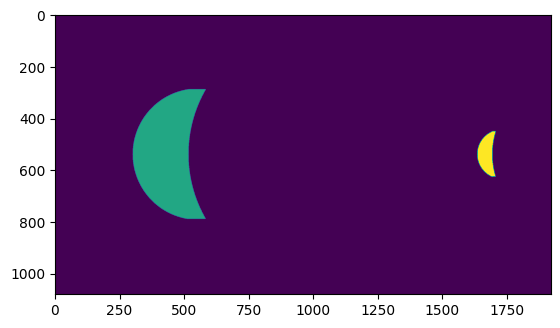

In [94]:
# Example usage
sceneHeight = 1080
sceneWidth = 1920
lens1X = 300

lensHeight1 = 500
f1 = 800 
R11 = 253  #first radius lens 1
R21 = 500  #second radius lens 1
n1 = 1.5

lensHeight2 = 175
f2 = 80    # mm
R12 = 95 #first radius lens 2 
R22 = 300  #second radius lens 2  
n2 = 2.5

# Example usage
array,vertices = generate_lens(
    array_height=sceneHeight,
    array_width=sceneWidth,
    rad1=R11,
    rad2= R21,
    cx = lens1X,
    cy = int(sceneHeight/2),
    clength = lensHeight1
)

thickness1 = -vertices[0] + vertices[1]
print("lens 1 vertices: ",vertices," thickness: ", thickness1)


array2,vertices2 = generate_lens(
    array_height = sceneHeight,
    array_width= sceneWidth,
    rad1= R12,
    rad2= R22,
    cx =int(sceneWidth * .5),
    cy = int(sceneHeight/2),
    clength = lensHeight2
)

thickness2 = -vertices2[0] + vertices2[1]
print("lens 2 vertices: ",vertices2," thickness: ", thickness2) 

R11solve = solve_R1(f1, R21, thickness1, n1)
R12solve = solve_R1(f2,R22, thickness2, n2)
print(f"Solved R11: {R11solve:.3f} ")
print(f"solved R12: {R12solve:.3f} ")

prinPoints = principlePoints(n1,f1,thickness1,R11,R12,vertices[0],vertices[1])
prinPoints2 = principlePoints(n2,f2,thickness2,R12,R22,vertices2[0],vertices2[1])

#the location where the second lenses front principle point should fall
targetLoc = prinPoints[1] + f1 + f2
print(prinPoints[1])
print(targetLoc)
#where the second lenses principle point actually falls
actualLoc = prinPoints2[0]
array2 = np.roll(array2,targetLoc - actualLoc,axis = 1)

#final lens array with index of refraction applied
lensArr = array*n1*100 + array2*n2*100

# lensArr[lensArr == 0] = 100
# ax = plt.hist(lensArr[lensArr != 100].flatten(), bins = 50)
plt.imshow(lensArr)
# plt.imshow(lensArr)
# plt.title('Single Circular Segment')
# plt.axis('off')
# plt.show()


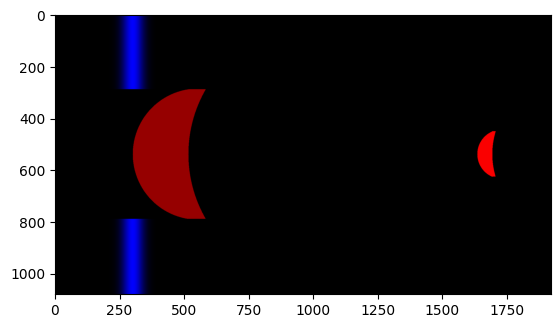

In [92]:
scene = aperture(height = sceneHeight,\
    width = sceneWidth,
    apHorz = lens1X,
    apVert = int(sceneHeight/2),
    apWidth = 20,
    apRad = int(lensHeight1/2))

#set the refractive indices of the scene
scene[:,:,0] = lensArr

plt.imshow(scene)
image = Image.fromarray(scene)
image.save("test.png")



